In [1]:
import pandas as pd
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 
from visual import find_opt_thres, get_metric_invariant, load_results
from matplotlib import pyplot as plt
from visual import load_csv
# evaluator = Evaluator(name='ogbl-collab')
evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/TAG-LP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   edge_index0  edge_index1      pred   gr
0           26          702  6.421436  1.0
1         2105         2328  2.130622  1.0
2          807         1921  5.570520  1.0
3          159         2095  6.383718  1.0
4          127          603  6.345405  1.0
best_accuracy: 0.9051383399209486, best_threshold: 0.16161616161616163


20it [00:00, 22.54it/s]
20it [00:00, 21.08it/s]


{'mrr_hit0.1': tensor(0.8814), 'mrr_hit0.2': tensor(0.9684), 'mrr_hit0.3': tensor(0.9881), 'mrr_hit0.5': tensor(0.9921), 'mrr_hit1.0': tensor(1.)}
{'AUC': 0.9669, 'AP': 0.9681}
{'mrr_hit0.1': tensor(0.), 'mrr_hit0.2': tensor(0.), 'mrr_hit0.3': tensor(0.), 'mrr_hit0.5': tensor(0.0040), 'mrr_hit1.0': tensor(1.)}


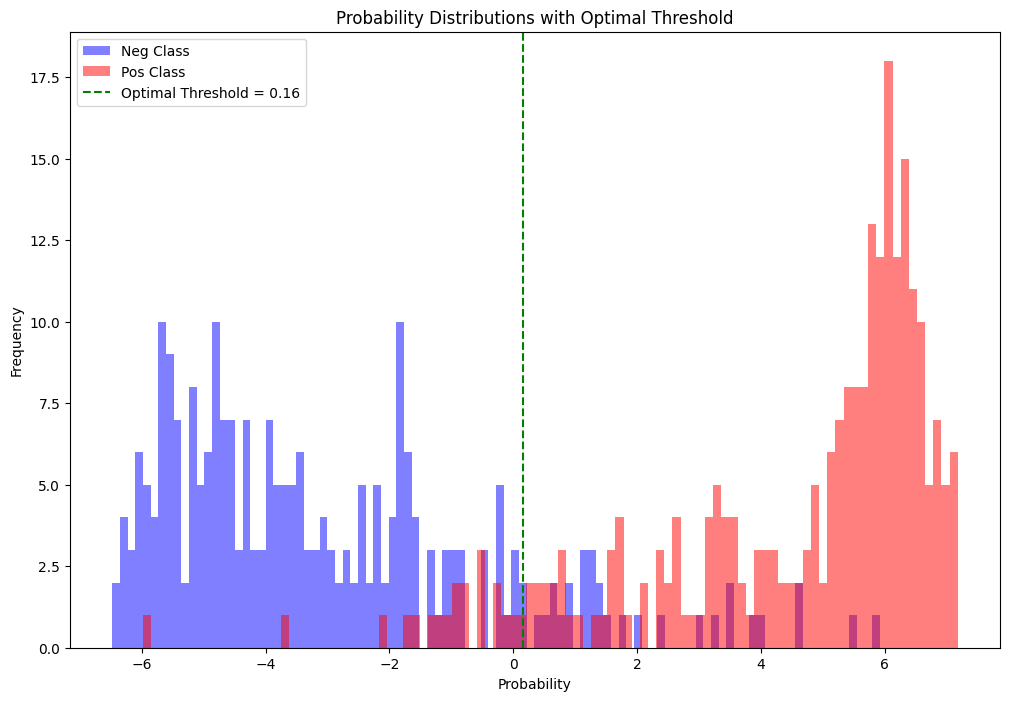

<Figure size 640x480 with 0 Axes>

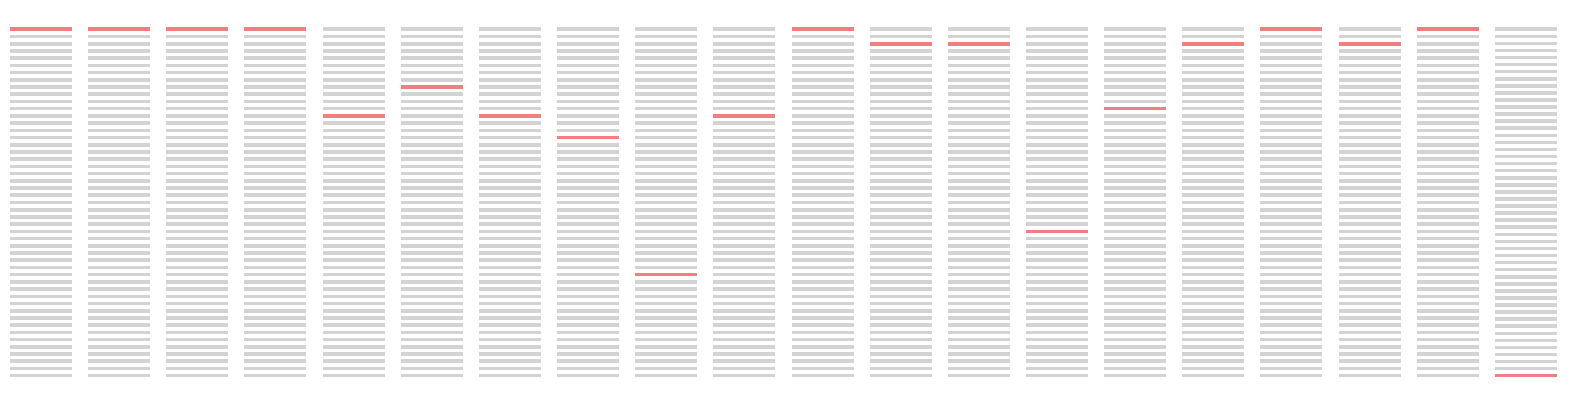

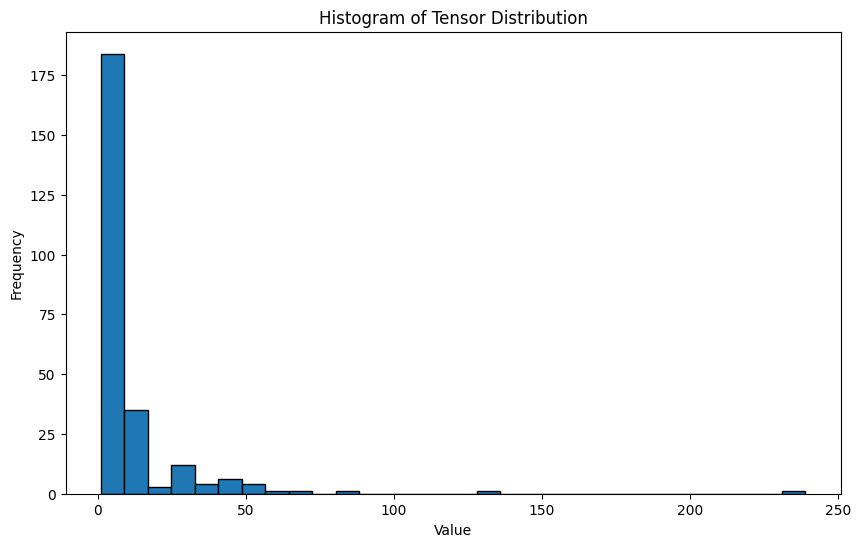

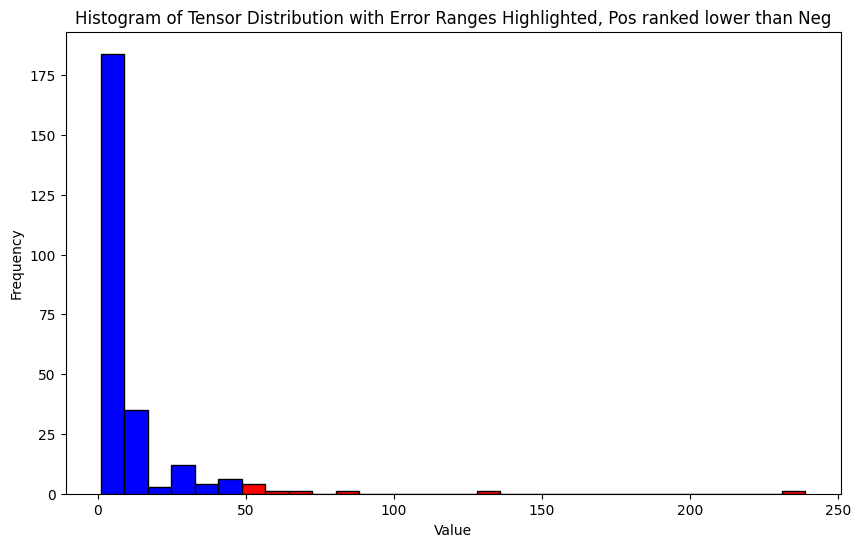

<Figure size 640x480 with 0 Axes>

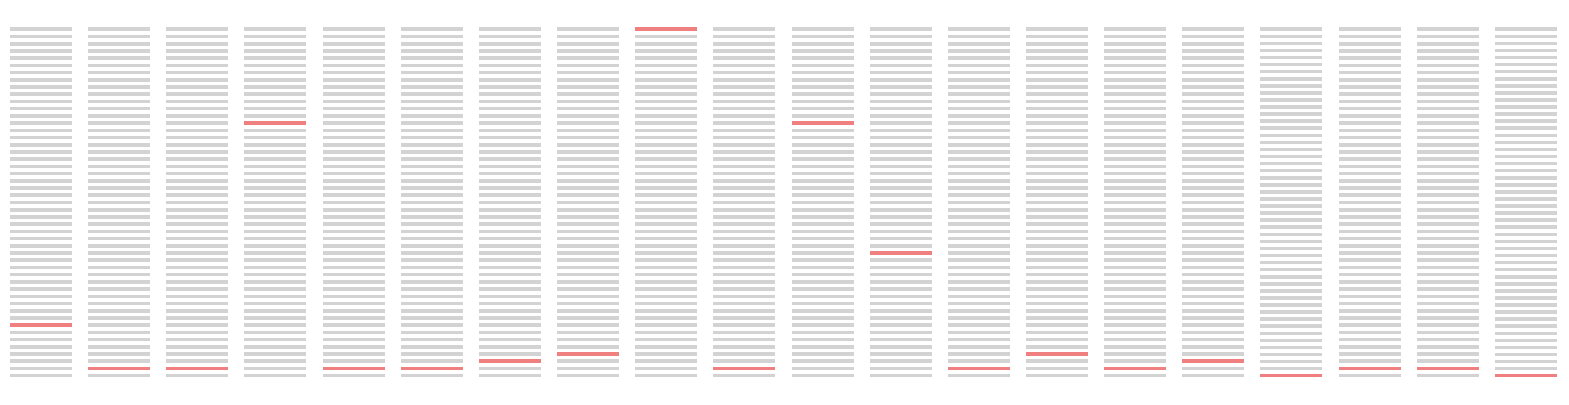

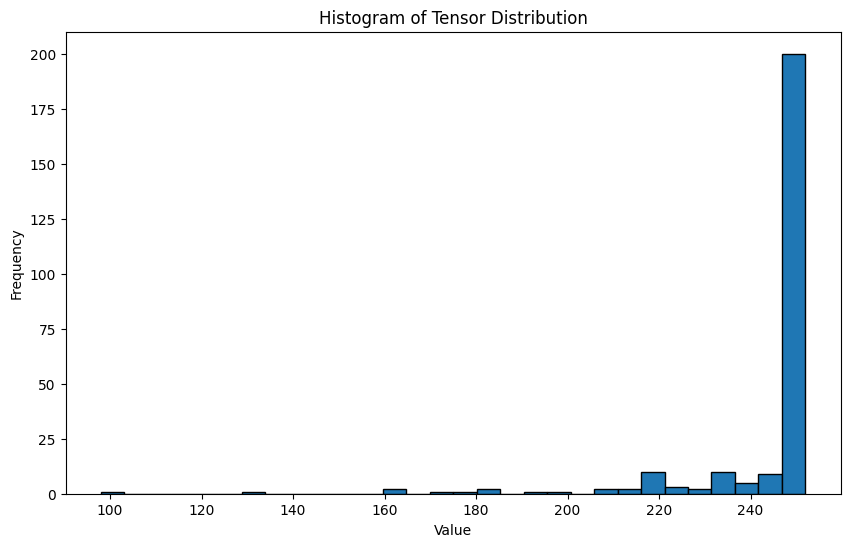

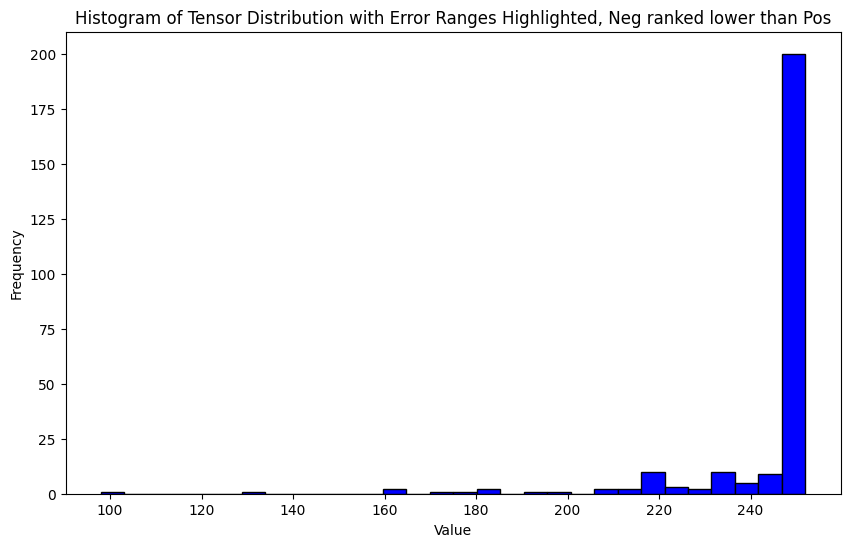

In [2]:
# Example usage
FILE_PATH = '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/educational_demo/'
file_path = FILE_PATH + 'err_ncnc_llama/ncnc-cora_AUC_0.9669_MRR_0.5275.csv'
P1, P2, pos_index, neg_index = load_results(file_path)
best_thres_llama, best_acc_llama, pos_pred_llama, neg_pred_llama = find_opt_thres(P1, P2)


plt.figure(figsize=(12, 8))
# Plot distributions of probabilities
plt.hist(P2, bins=100, alpha=0.5, color='blue', label='Neg Class')
plt.hist(P1, bins=100, alpha=0.5, color='red', label='Pos Class')
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)

plt.axvline(best_thres, color='green', linestyle='--', label=f'Optimal Threshold = {best_thres:.2f}')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distributions with Optimal Threshold')
plt.savefig('optimal_threshold.png')
print(f'best_accuracy: {best_acc}, best_threshold: {best_thres}')

k_list  = [0.1, 0.2, 0.3, 0.5, 1]
pos_index = torch.tensor(pos_index)
neg_index = torch.tensor(neg_index)
P1 = torch.tensor(P1)
P2 = torch.tensor(P2)
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

print(mrr_pos2neg)
print(result_auc_test)
print(mrr_neg2pos)


In [3]:
import os
import sys

# Assuming your target directory is one level up from the current working directory
notebook_dir = os.getcwd()  
target_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

sys.path.insert(0, target_dir)
from core.data_utils.load import load_data_lp
from core.graphgps.utility.utils import init_cfg_test

cfg = init_cfg_test()

In [4]:
splits, text, data = load_data_lp[cfg.data.name](cfg.data)

not loaded 0 papers.
create graph: 0.07382941246032715
[2485]
original num of nodes: 2485
num of nodes after lcc: 2485
num of edges after lcc: 10138
num of texts in dataset: 2485


In [5]:
splits

{'train': Data(x=[2485, 1433], edge_index=[2, 8112], num_nodes=2485, node_attrs=[2485, 1433], pos_edge_label=[4056], pos_edge_label_index=[2, 4056], neg_edge_label=[4056], neg_edge_label_index=[2, 4056]),
 'valid': Data(x=[2485, 1433], edge_index=[2, 8112], num_nodes=2485, node_attrs=[2485, 1433], pos_edge_label=[760], pos_edge_label_index=[2, 760], neg_edge_label=[760], neg_edge_label_index=[2, 760]),
 'test': Data(x=[2485, 1433], edge_index=[2, 9632], num_nodes=2485, node_attrs=[2485, 1433], pos_edge_label=[253], pos_edge_label_index=[2, 253], neg_edge_label=[253], neg_edge_label_index=[2, 253])}

In [6]:
data

Data(x=[2485, 1433], edge_index=[2, 10138], num_nodes=2485, node_attrs=[2485, 1433])

In [7]:
print(f'index predicted to be neg when pos : {pos_edge_index_err.shape}')
print(f'index predicted to be pos when neg : {neg_edge_index_err.shape}')

index predicted to be neg when pos : torch.Size([9, 2])
index predicted to be pos when neg : torch.Size([1, 2])


## What Pos is predicted as Neg? Type II.

In [8]:
for row in pos_edge_index_err:
    print(f'source: {text[row[0]]}, \n target: {text[row[1]]}')

source: Title: Interactive Segmentation of Three-dimensional Medical Images (Extended abstract)  
Abstract: We had previously shown that regularization principles lead to approximation schemes which are equivalent to networks with one layer of hidden units, called Regularization Networks. In particular, standard smoothness functionals lead to a subclass of regularization networks, the well known Radial Basis Functions approximation schemes. This paper shows that regularization networks encompass a much broader range of approximation schemes, including many of the popular general additive models and some of the neural networks. In particular, we introduce new classes of smoothness functionals that lead to different classes of basis functions. Additive splines as well as some tensor product splines can be obtained from appropriate classes of smoothness functionals. Furthermore, the same generalization that extends Radial Basis Functions (RBF) to Hyper Basis Functions (HBF) also leads fro

In [9]:
from IPython.display import display, Markdown

for row in pos_edge_index_err:
    src = text[row[0]]
    tgt = text[row[1]]
    display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))

**Source:** Title: Interactive Segmentation of Three-dimensional Medical Images (Extended abstract)  
Abstract: We had previously shown that regularization principles lead to approximation schemes which are equivalent to networks with one layer of hidden units, called Regularization Networks. In particular, standard smoothness functionals lead to a subclass of regularization networks, the well known Radial Basis Functions approximation schemes. This paper shows that regularization networks encompass a much broader range of approximation schemes, including many of the popular general additive models and some of the neural networks. In particular, we introduce new classes of smoothness functionals that lead to different classes of basis functions. Additive splines as well as some tensor product splines can be obtained from appropriate classes of smoothness functionals. Furthermore, the same generalization that extends Radial Basis Functions (RBF) to Hyper Basis Functions (HBF) also leads from additive models to ridge approximation models, containing as special cases Breiman's hinge functions, some forms of Projection Pursuit Regression and several types of neural networks. We propose to use the term Generalized Regularization Networks for this broad class of approximation schemes that follow from an extension of regularization. In the probabilistic interpretation of regularization, the different classes of basis functions correspond to different classes of prior probabilities on the approximating function spaces, and therefore to different types of smoothness assumptions. In summary, different multilayer networks with one hidden layer, which we collectively call Generalized Regularization Networks, correspond to different classes of priors and associated smoothness functionals in a classical regularization principle. Three broad classes are a) Radial Basis Functions that can be generalized to Hyper Basis Functions, b) some tensor product splines, and c) additive splines that can be generalized to schemes of the type of ridge approximation, hinge functions and several perceptron-like neural networks with one-hidden layer. 1 This paper will appear on Neural Computation, vol. 7, pages 219-269, 1995. An earlier version of   
**Target:** Title: Parzen. On estimation of a probability density function and mode. Annual Mathematical Statistics, 33:1065-1076, 1962.
Abstract: To apply the algorithm for classification we assign each class a separate set of codebook Gaussians. Each set is only trained with patterns from a single class. After having trained the codebook Gaussians, each set provides an estimate of the probability function of one class; just as with Parzen window estimation, we take as the estimate of the pattern distribution the average of all Gaussians in the set. Classification of a pattern may now be done by calculating the probability of each class at the respective sample point, and assigning to the pattern the class with the highest probability. Hence the whole codebook plays a role in the classification of patterns. This is not the case with regular classification schemes using codebooks. We have tested the classification scheme on several classification tasks including the two spiral problem. We compared our algorithm to various other classification algorithms and it came out second; the best algorithm for the applications is the Parzen window estimation. However, the computing time and memory for Parzen window estimation are excessive when compared to our algorithm, and hence, in practical situations, our algorithm is to be preferred. We have developed a fast algorithm which combines attractive properties of both Parzen window estimation and vector quantization. The scale parameter is tuned adaptively and, therefore, is not set in an ad hoc manner. It allows a classification strategy in which all the codebook vectors are taken into account. This yields better results than the standard vector quantization techniques. An interesting topic for further research is to use radially non-symmetric Gaussians. 

**Source:** Title: Support Vector Machines: Training and Applications  
Abstract: The Support Vector Machine (SVM) is a new and very promising classification technique developed by Vapnik and his group at AT&T Bell Laboratories [3, 6, 8, 24]. This new learning algorithm can be seen as an alternative training technique for Polynomial, Radial Basis Function and Multi-Layer Perceptron classifiers. The main idea behind the technique is to separate the classes with a surface that maximizes the margin between them. An interesting property of this approach is that it is an approximate implementation of the Structural Risk Minimization (SRM) induction principle [23]. The derivation of Support Vector Machines, its relationship with SRM, and its geometrical insight, are discussed in this paper. Since Structural Risk Minimization is an inductive principle that aims at minimizing a bound on the generalization error of a model, rather than minimizing the Mean Square Error over the data set (as Empirical Risk Minimization methods do), training a SVM to obtain the maximum margin classifier requires a different objective function. This objective function is then optimized by solving a large-scale quadratic programming problem with linear and box constraints. The problem is considered challenging, because the quadratic form is completely dense, so the memory needed to store the problem grows with the square of the number of data points. Therefore, training problems arising in some real applications with large data sets are impossible to load into memory, and cannot be solved using standard non-linear constrained optimization algorithms. We present a decomposition algorithm that can be used to train SVM's over large data sets. The main idea behind the decomposition is the iterative solution of sub-problems and the evaluation of, and also establish the stopping criteria for the algorithm. We present previous approaches, as well as results and important details of our implementation of the algorithm using a second-order variant of the Reduced Gradient Method as the solver of the sub-problems. As an application of SVM's, we present preliminary results in Frontal Human Face Detection in images. This application opens many interesting questions and future research opportunities, both in the context of faster and better optimization algorithms, and in the use of SVM's in other pattern classification, recognition, and detection applications. This report describes research done within the Center for Biological and Computational Learning in the Department of Brain and Cognitive Sciences and the Artificial Intelligence Laboratory at the Massachusetts Institute of Technology. This research is sponsored by MURI grant N00014-95-1-0600; by a grant from ONR/ARPA under contract N00014-92-J-1879 and by the National Science Foundation under contract ASC-9217041 (this award includes funds from ARPA provided under the HPCC program). Edgar Osuna was supported by Fundacion Gran Mariscal de Ayacucho and Daimler Benz. Additional support is provided by Daimler-Benz, Eastman Kodak Company, Siemens Corporate Research, Inc. and AT&T.   
**Target:** Title: Human Face Detection in Visual Scenes  
Abstract: We present a neural network-based face detection system. A retinally connected neural network examines small windows of an image, and decides whether each window contains a face. The system arbitrates between multiple networks to improve performance over a single network. We use a bootstrap algorithm for training, which adds false detections into the training set as training progresses. This eliminates the difficult task of manually selecting non-face training examples, which must be chosen to span the entire space of non-face images. Comparisons with another state-of-the-art face detection system are presented; our system has better performance in terms of detection and false-positive rates.

**Source:** Title: LEARNING MORE FROM LESS DATA: EXPERIMENTS WITH LIFELONG ROBOT LEARNING  
Abstract: Most connectionist modeling assumes noise-free inputs. This assumption is often violated. This paper introduces the idea of clearning, of simultaneously cleaning the data and learning the underlying structure. The cleaning step can be viewed as top-down processing (where the model modifies the data), and the learning step can be viewed as bottom-up processing (where the data modifies the model). Clearning is used in conjunction with standard pruning. This paper discusses the statistical foundation of clearning, gives an interpretation in terms of a mechanical model, describes how to obtain both point predictions and conditional densities for the output, and shows how the resulting model can be used to discover properties of the data otherwise not accessible (such as the signal-to-noise ratio of the inputs). This paper uses clearning to predict foreign exchange rates, a noisy time series problem with well-known benchmark performances. On the out-of-sample 1993-1994 test period, clearning obtains an annualized return on investment above 30%, significantly better than an otherwise identical network. The final ultra-sparse network with 36 remaining non-zero input-to-hidden weights (of the 1035 initial weights between 69 inputs and 15 hidden units) is very robust against overfitting. This small network also lends itself to interpretation.  
**Target:** Title: Clustering Learning Tasks and the Selective Cross-Task Transfer of Knowledge  
Abstract: This research is sponsored in part by the National Science Foundation under award IRI-9313367, and by the Wright Laboratory, Aeronautical Systems Center, Air Force Materiel Command, USAF, and the Advanced Research Projects Agency (ARPA) under grant number F33615-93-1-1330. The views and conclusions contained in this document are those of the author and should not be interpreted as necessarily representing official policies or endorsements, either expressed or implied, of NSF, Wright Laboratory or the United States Government. 

**Source:** Title: Learning Concepts from Sensor Data of a Mobile Robot  
Abstract: Machine learning can be a most valuable tool for improving the flexibility and efficiency of robot applications. Many approaches to applying machine learning to robotics are known. Some approaches enhance the robot's high-level processing, the planning capabilities. Other approaches enhance the low-level processing, the control of basic actions. In contrast, the approach presented in this paper uses machine learning for enhancing the link between the low-level representations of sensing and action and the high-level representation of planning. The aim is to facilitate the communication between the robot and the human user. A hierarchy of concepts is learned from route records of a mobile robot. Perception and action are combined at every level, i.e., the concepts are perceptually anchored. The relational learning algorithm grdt has been developed which completely searches in a hypothesis space, that is restricted by rule schemata, which the user defines in terms of grammars.   
**Target:** Title: Learning Controllers for Industrial Robots  
Abstract: One of the most significant cost factors in robotics applications is the design and development of real-time robot control software. Control theory helps when linear controllers have to be developed, but it doesn't sufficiently support the generation of non-linear controllers, although in many cases (such as in compliance control), nonlinear control is essential for achieving high performance. This paper discusses how Machine Learning has been applied to the design of (non-)linear controllers. Several alternative function approximators, including Multilayer Perceptrons (MLP), Radial Basis Function Networks (RBFNs), and Fuzzy Controllers are analyzed and compared, leading to the definition of two major families: Open Field Function Function Approximators and Locally Receptive Field Function Approximators. It is shown that RBFNs and Fuzzy Controllers bear strong similarities, and that both have a symbolic interpretation. This characteristics allows for applying both symbolic and statistic learning algorithms to synthesize the network layout from a set of examples and, possibly, some background knowledge. Three integrated learning algorithms, two of which are original, are described and evaluated on experimental test cases. The first test case is provided by a robot KUKA IR-361 engaged into the "peg-into-hole" task, whereas the second is represented by a classical prediction task on the Mackey-Glass time series. From the experimental comparison, it appears that both Fuzzy Controllers and RBFNs synthesised from examples are excellent approximators, and that, in practice, they can be even more accurate than MLPs. 

**Source:** Title: Incremental Class Learning approach and its application to Handwritten Digit Recognition  
Abstract: Incremental Class Learning (ICL) provides a feasible framework for the development of scalable learning systems. Instead of learning a complex problem at once, ICL focuses on learning subproblems incrementally, one at a time | using the results of prior learning for subsequent learning | and then combining the solutions in an appropriate manner. With respect to multi-class classification problems, the ICL approach presented in this paper can be summarized as follows. Initially the system focuses on one category. After it learns this category, it tries to identify a compact subset of features (nodes) in the hidden layers, that are crucial for the recognition of this category. The system then freezes these crucial nodes (features) by fixing their incoming weights. As a result, these features cannot be obliterated in subsequent learning. These frozen features are available during subsequent learning and can serve as parts of weight structures build to recognize other categories. As more categories are learned, the set of features gradually stabilizes and learning a new category requires less effort. Eventually, learning a new category may only involve combining existing features in an appropriate manner. The approach promotes the sharing of learned features among a number of categories and also alleviates the well-known catastrophic interference problem. We present results of applying the ICL approach to the Handwritten Digit Recognition problem, based on a spatio-temporal representation of patterns.   
**Target:** Title: Learning One More Thing  
Abstract: Most research on machine learning has focused on scenarios in which a learner faces a single, isolated learning task. The lifelong learning framework assumes that the learner encounters a multitude of related learning tasks over its lifetime, providing the opportunity for the transfer of knowledge among these. This paper studies lifelong learning in the context of binary classification. It presents the invariance approach, in which knowledge is transferred via a learned model of the invariances of the domain. Results on learning to recognize objects from color images demonstrate superior generalization capabilities if invariances are learned and used to bias subsequent learning.

**Source:** Title: Generalizing from Case Studies: A Case Study  
Abstract: Most empirical evaluations of machine learning algorithms are case studies evaluations of multiple algorithms on multiple databases. Authors of case studies implicitly or explicitly hypothesize that the pattern of their results, which often suggests that one algorithm performs significantly better than others, is not limited to the small number of databases investigated, but instead holds for some general class of learning problems. However, these hypotheses are rarely supported with additional evidence, which leaves them suspect. This paper describes an empirical method for generalizing results from case studies and an example application. This method yields rules describing when some algorithms significantly outperform others on some dependent measures. Advantages for generalizing from case studies and limitations of this particular approach are also described.  
**Target:** Title: Systematic Evaluation of Design Decisions in CBR Systems  
Abstract: Two important goals in the evaluation of an AI theory or model are to assess the merit of the design decisions in the performance of an implemented computer system and to analyze the impact in the performance when the system faces problem domains with different characteristics. This is particularly difficult in case-based reasoning systems because such systems are typically very complex, as are the tasks and domains in which they operate. We present a methodology for the evaluation of case-based reasoning systems through systematic empirical experimentation over a range of system configurations and environmental conditions, coupled with rigorous statistical analysis of the results of the experiments. This methodology enables us to understand the behavior of the system in terms of the theory and design of the computational model, to select the best system configuration for a given domain, and to predict how the system will behave in response to changing domain and problem characteristics. A case study of a mul-tistrategy case-based and reinforcement learning system which performs autonomous robotic navigation is presented as an example. 

**Source:** Title: Induction of Multiscale Temporal Structure  
Abstract: Learning structure in temporally-extended sequences is a difficult computational problem because only a fraction of the relevant information is available at any instant. Although variants of back propagation can in principle be used to find structure in sequences, in practice they are not sufficiently powerful to discover arbitrary contingencies, especially those spanning long temporal intervals or involving high order statistics. For example, in designing a connectionist network for music composition, we have encountered the problem that the net is able to learn musical structure that occurs locally in time|e.g., relations among notes within a musical phrase|but not structure that occurs over longer time periods|e.g., relations among phrases. To address this problem, we require a means of constructing a reduced description of the sequence that makes global aspects more explicit or more readily detectable. I propose to achieve this using hidden units that operate with different time constants. Simulation experiments indicate that slower time-scale hidden units are able to pick up global structure, structure that simply can not be learned by standard Many patterns in the world are intrinsically temporal, e.g., speech, music, the unfolding of events. Recurrent neural net architectures have been devised to accommodate time-varying sequences. For example, the architecture shown in Figure 1 can map a sequence of inputs to a sequence of outputs. Learning structure in temporally-extended sequences is a difficult computational problem because the input pattern may not contain all the task-relevant information at any instant. Thus, back propagation.  
**Target:** Title: Diffusion of Context and Credit Information in Markovian Models  
Abstract: This paper studies the problem of ergodicity of transition probability matrices in Marko-vian models, such as hidden Markov models (HMMs), and how it makes very difficult the task of learning to represent long-term context for sequential data. This phenomenon hurts the forward propagation of long-term context information, as well as learning a hidden state representation to represent long-term context, which depends on propagating credit information backwards in time. Using results from Markov chain theory, we show that this problem of diffusion of context and credit is reduced when the transition probabilities approach 0 or 1, i.e., the transition probability matrices are sparse and the model essentially deterministic. The results found in this paper apply to learning approaches based on continuous optimization, such as gradient descent and the Baum-Welch algorithm. 

**Source:** Title: A Polynomial Time Incremental Algorithm for Regular Grammar Inference  
Abstract: This paper develops probabilistic bounds on out-of-sample error rates for several classifiers using a single set of in-sample data. The bounds are based on probabilities over partitions of the union of in-sample and out-of-sample data into in-sample and out-of-sample data sets. The bounds apply when in-sample and out-of-sample data are drawn from the same distribution. Partition-based bounds are stronger than VC-type bounds, but they require more computation.   
**Target:** Title: Learning DFA from Simple Examples  
Abstract: We present a framework for learning DFA from simple examples. We show that efficient PAC learning of DFA is possible if the class of distributions is restricted to simple distributions where a teacher might choose examples based on the knowledge of the target concept. This answers an open research question posed in Pitt's seminal paper: Are DFA's PAC-identifiable if examples are drawn from the uniform distribution, or some other known simple distribution? Our approach uses the RPNI algorithm for learning DFA from labeled examples. In particular, we describe an efficient learning algorithm for exact learning of the target DFA with high probability when a bound on the number of states (N ) of the target DFA is known in advance. When N is not known, we show how this algorithm can be used for efficient PAC learning of DFAs. 

**Source:** Title: A utility-based approach to learning in a mixed Case-Based and Model-Based Reasoning architecture  
Abstract: Case-based reasoning (CBR) can be used as a form of "caching" solved problems to speedup later problem solving. Using "cached" cases brings additional costs with it due to retrieval time, case adaptation time and also storage space. Simply storing all cases will result in a situation in which retrieving and trying to adapt old cases will take more time (on average) than not caching at all. This means that caching must be applied selectively to build a case memory that is actually useful. This is a form of the utility problem [4, 2]. The approach taken here is to construct a "cost model" of a system that can be used to predict the effect of changes to the system. In this paper we describe the utility problem associated with "caching" cases and the construction of a "cost model". We present experimental results that demonstrate that the model can be used to predict the effect of certain changes to the case memory.  
**Target:** Title: A Performance Model for Knowledge-based Systems  
Abstract: Most techniques for verification and validation are directed at functional properties of programs. However, other properties of programs are also essential. This paper describes a model for the average computing time of a KADS knowledge-based system based on its structure. An example taken from an existing knowledge-based system is used to demonstrate the use of the cost-model in designing the system. 

## Analysis for Error I
https://24timezones.com/difference/frankfurt_ger/new_delhi?dt=2024-07-31T830pm 
1. Such citation indeed exists, however, it appears in a historical section.
| ![Example Image](intro.png) |![Example Image](ref.png) |

## Analysis for Error II 
1. textual features are quite noisy. 

**Target:**

**Title:** Cholinergic Suppression of Transmission May Allow Combined Associative Memory Function and Self-Organization in the Neocortex

**Abstract:** Selective suppression of transmission at feedback synapses during learning is proposed as a mechanism for combining associative feedback with self-organization of feedforward synapses. Experimental data demonstrates cholinergic suppression of synaptic transmission in layer I (feedback synapses), and a lack of suppression in layer IV (feed-forward synapses). A network with this feature uses local rules to learn mappings which are not linearly separable. During learning, sensory stimuli and desired responses are simultaneously presented as input. Feedforward connections form self-organized representations of input, while suppressed feedback connections learn the transpose of feedforward connectivity. During recall, suppression is removed, sensory input activates the self-organized representation, and activity generates the learned response.

### No idea what the hell is this? Title is the Figure description and abstract is followed by the reference?

**Source:**

**Title:** Figure 8: Time Complexity of Unit Parallelism Measured on MANNA Theoretical Prediction #nodes N Time

**Abstract:** Our experience showed us that flexibility in expressing a parallel algorithm for simulating neural networks is desirable even if it is not possible then to obtain the most efficient solution for any single training algorithm. We believe that the advantages of a clear and easy-to-understand program predominate the disadvantages of approaches allowing only for a specific machine or neural network algorithm. We currently investigate if other neural network models are worthwhile being parallelized, and how the resulting parallel algorithms can be composed of a few common basic building blocks and the logarithmic tree as an efficient communication structure.

**References:**
1. D. Ackley, G. Hinton, T. Sejnowski: *A Learning Algorithm for Boltzmann Machines*, Cognitive Science 9, pp. 147-169, 1985
2. B. M. Forrest et al.: *Implementing Neural Network Models on Parallel Computers*, The Computer Journal, vol. 30, no. 5, 1987
3. W. Giloi: *Latency Hiding in Message Passing Architectures*, International Parallel Processing Symposium, April 1994, Cancun, Mexico, IEEE Computer Society Press
4. T. Nordström, B. Svensson: *Using And Designing Massively Parallel Computers for Artificial Neural Networks*, Journal Of Parallel And Distributed Computing, vol. 14, pp. 260-285, 1992
5. A. Kramer, A. Vincentelli: *Efficient Parallel Learning Algorithms for Neural Networks*, Advances in Neural Information Processing Systems I, D. Touretzky (ed.), pp. 40-48, 1989
6. T. Kohonen: *Self-Organization and Associative Memory*, Springer-Verlag, Berlin, 1988
7. D. A. Pomerleau, G. L. Gusciora, D. L. Touretzky, H. T. Kung: *Neural Network Simulation at Warp Speed: How We Got 17 Million Connections Per Second*, IEEE Intern. Conf. Neural Networks, July 1988
8. A. Rübel: *Dynamic Selection of Training Patterns for Neural Networks: A New Method to Control the Generalization*, Technical Report 92-39, Technical University of Berlin, 1993
9. D. E. Rumelhart, D. E. Hinton, R. J. Williams: *Learning Internal Representations by Error Propagation*, Rumelhart & McClelland (eds.), Parallel Distributed Processing: Explorations in the Microstructure of Cognition, vol. I, pp. 318-362, Bradford Books/MIT Press, Cambridge, MA, 1986
10. W. Schiffmann, M. Joost, R. Werner: *Comparison of Optimized Backpropagation Algorithms*, Proc. of the European Symposium on Artificial Neural Networks, ESANN '93, Brussels, pp. 97-104, 1993
11. J. Schmidhuber: *Accelerated Learning in BackPropagation Nets*, Connectionism in Perspective, Elsevier Science Publishers B.V. (North-Holland), pp 439-445, 1989
12. M. Taylor, P. Lisboa (eds.): *Techniques and Applications of Neural Networks*, Ellis Horwood, 1993
13. M. Witbrock, M. Zagha: *An Implementation of Backpropagation Learning on GF11, a Large SIMD Parallel Computer*, Parallel Computing, vol. 14, pp. 329-346, 1990
14. X. Zhang, M. McKenna, J. P. Mesirov, D. L. Waltz: *The Backpropagation Algorithm on Grid and Hypercube Architectures*, Parallel Computing, vol. 14, pp. 317-327, 1990

In [10]:
from IPython.display import display, Markdown

for row in neg_edge_index_err:
    src = text[row[0]]
    tgt = text[row[1]]
    display(Markdown(f"**Source:** {src}  \n**Target:** {tgt}"))

**Source:** Title: Learning from incomplete data  
Abstract: Real-world learning tasks often involve high-dimensional data sets with complex patterns of missing features. In this paper we review the problem of learning from incomplete data from two statistical perspectives|the likelihood-based and the Bayesian. The goal is two-fold: to place current neural network approaches to missing data within a statistical framework, and to describe a set of algorithms, derived from the likelihood-based framework, that handle clustering, classification, and function approximation from incomplete data in a principled and efficient manner. These algorithms are based on mixture modeling and make two distinct appeals to the Expectation-Maximization (EM) principle (Dempster et al., 1977)|both for the estimation of mixture components and for coping with the missing data. This report describes research done at the Center for Biological and Computational Learning and the Artificial Intelligence Laboratory of the Massachusetts Institute of Technology. Support for the Center is provided in part by a grant from the National Science Foundation under contract ASC-9217041. Support for the laboratory's artificial intelligence research is provided in part by the Advanced Research Projects Agency of the Department of Defense. The authors were supported in part by a grant from ATR Auditory and Visual Perception Research Laboratories, by a grant from Siemens Corporation, by grant IRI-9013991 from the National Science Foundation, and by grant N00014-90-J-1942 from the Office of Naval Research. Zoubin Ghahramani was supported by a grant from the McDonnell-Pew Foundation. Michael I. Jordan is a NSF Presidential Young Investigator.   
**Target:** Title: Cholinergic suppression of transmission may allow combined associative memory function and self-organization in the neocortex.  
Abstract: Selective suppression of transmission at feedback synapses during learning is proposed as a mechanism for combining associative feedback with self-organization of feedforward synapses. Experimental data demonstrates cholinergic suppression of synaptic transmission in layer I (feedback synapses), and a lack of suppression in layer IV (feed-forward synapses). A network with this feature uses local rules to learn mappings which are not linearly separable. During learning, sensory stimuli and desired response are simultaneously presented as input. Feedforward connections form self-organized representations of input, while suppressed feedback connections learn the transpose of feedfor-ward connectivity. During recall, suppression is removed, sensory input activates the self-organized representation, and activity generates the learned response.

In [11]:
def adamic_adar(adj, node1, node2):
    """计算Adamic-Adar指数"""
    neighbors1 = adj[node1].nonzero(as_tuple=False).flatten()
    neighbors2 = adj[node2].nonzero(as_tuple=False).flatten()
    common_neighbors = torch.tensor(list(set(neighbors1.tolist()).intersection(set(neighbors2.tolist()))))
    index = adj.sum(dim=0).squeeze()
    aa_score = sum(1.0 / torch.log1p(index[neighbor].float()) for neighbor in common_neighbors)
    return aa_score

def resource_allocation(adj, node1, node2):
    """计算资源分配指数"""
    neighbors1 = adj[node1].nonzero(as_tuple=False).flatten()
    neighbors2 = adj[node2].nonzero(as_tuple=False).flatten()
    common_neighbors = torch.tensor(list(set(neighbors1.tolist()).intersection(set(neighbors2.tolist()))))
    index = adj.sum(dim=0).squeeze()
    ra_score = sum(1.0 / index[neighbor].float() for neighbor in common_neighbors)
    return ra_score

def pagerank(adj, node, alpha=0.85, max_iter=100):
    """计算PageRank得分"""
    n = adj.size(0)
    ranks = torch.ones(n, dtype=torch.float32) / n
    for _ in range(max_iter):
        new_ranks = (1 - alpha) / n + alpha * adj @ ranks
        if torch.allclose(new_ranks, ranks, atol=1e-6):
            break
        ranks = new_ranks
    return ranks[node]

def katz(adj, node1, node2, alpha=0.005, beta=0.005, max_iter=1000):
    """计算Katz得分"""
    n = adj.size(0)
    I = torch.eye(n)
    katz_matrix = alpha * I + beta * adj
    katz_scores = torch.linalg.pinv(katz_matrix) @ torch.ones(n, dtype=torch.float32)

    return katz_scores[node1] + katz_scores[node2]

def shortest_path_length(adj, node1, node2):
    """计算最短路径长度"""
    n = adj.size(0)
    dist = torch.full((n, n), float('inf'))
    dist[torch.arange(n), torch.arange(n)] = 0
    for i in range(adj.size(0)):
        for j in range(adj.size(0)):
            if adj[i, j] != 0:
                dist[i, j] = 1
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist[i, j] > dist[i, k] + dist[k, j]:
                    dist[i, j] = dist[i, k] + dist[k, j]
    return dist[node1, node2]

In [12]:
from torch_geometric import utils
from data_utils.lcc import use_lcc

splits, text, data = load_data_lp[cfg.data.name](cfg.data)
# new_data, lcc_index, G = use_lcc(data)
G = utils.to_dense_adj(data.edge_index).squeeze()
G

not loaded 0 papers.
create graph: 0.12021589279174805
[2485]
original num of nodes: 2485
num of nodes after lcc: 2485
num of edges after lcc: 10138
num of texts in dataset: 2485


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [13]:
pos_edge_index_err.shape

torch.Size([9, 2])

In [14]:
for row in pos_edge_index_err:
    src = row[0]
    tgt = row[1]
    try:
        print("Adamic-Adar:", adamic_adar(G, src, tgt))
        print("Resource Allocation:", resource_allocation(G, src, tgt))
        print("PageRank:", pagerank(G, src))
        print("Katz:", katz(G, src, tgt))
        print("Shortest Path Length:", shortest_path_length(G, src, tgt))
    except:
        print("Error")

Adamic-Adar: tensor(0.2316)
Resource Allocation: tensor(0.0135)
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error
Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
Error


In [15]:
for row in neg_edge_index_err:
    src = row[0]
    tgt = row[1]
    print("Adamic-Adar:", adamic_adar(G, src, tgt))
    print("Resource Allocation:", resource_allocation(G, src, tgt))
    print("PageRank:", pagerank(G, src))
    print("PageRank:", pagerank(G, tgt))
    print("Katz:", katz(G, src, tgt))

Adamic-Adar: 0
Resource Allocation: 0
PageRank: tensor(nan)
PageRank: tensor(nan)


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 1).

In [16]:
count = splits['test']['pos_edge_label_index'].T.size(0)
AA = 0
RA = 0
Katz = 0
for row in splits['test']['pos_edge_label_index'].T:
    src = row[0]
    tgt = row[1]
    AA += adamic_adar(G, src, tgt)
    RA += resource_allocation(G, src, tgt)
    Katz += katz(G, src, tgt)
    
print("mAA:", AA/count)
print("mRA:", RA/count)
print("mKatz:", Katz/count)

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 1).